## Setup

In [1]:
# Adapted from: https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

In [2]:
if IS_COLAB:
    %pip install lifelines==0.27.0

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

## 11.3 The Kaplan-Meier Survival Curve


In [4]:
df_cancer = pd.read_csv('https://raw.githubusercontent.com/wpan03/ISLRv2_Python/main/data/brain_cancer.csv')

In [5]:
df_cancer.head() 

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
1,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
2,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
3,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
4,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30


Most software, including R, uses the convention that status = 1 indicates an uncensored observation, and status = 0 indicates a censored observation. 

In [6]:
df_cancer.status.value_counts()

0    53
1    35
Name: status, dtype: int64

In [7]:
num_survive_20 = df_cancer.query("time >= 20").shape[0]
num_survive_20

48

In [8]:
censor_before_20 = df_cancer.query("time < 20 & status == 0").shape[0]
censor_before_20

17

In [9]:
num_not_censor = df_cancer.query("status == 1").shape[0]
num_survive_20 + num_not_censor - df_cancer.query("time >= 20 & status == 1").shape[0]

71

In [10]:
kmf = KaplanMeierFitter()

In [11]:
kmf.fit(df_cancer['time'], event_observed=df_cancer['status'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 88 total observations, 53 right-censored observations>

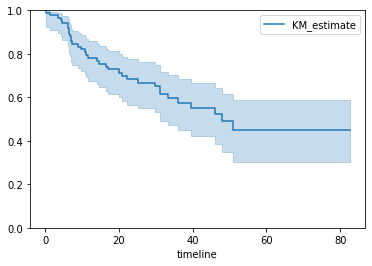

In [12]:
kmf.plot_survival_function()
plt.ylim([0, 1])
plt.show()

## 11.4 Log-Rank Test

In [13]:
df_cancer.head()

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
1,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
2,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
3,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
4,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30


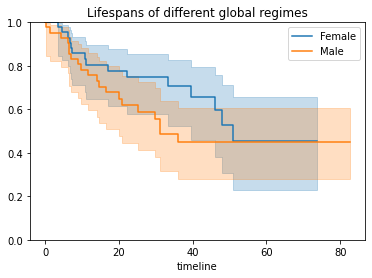

In [14]:
ax = plt.subplot(111)

is_female = (df_cancer["sex"] == "Female")

kmf.fit(df_cancer[is_female]['time'],
        event_observed=df_cancer[is_female]['status'],
        label="Female")
kmf.plot_survival_function(ax=ax)

kmf.fit(df_cancer[~is_female]['time'],
        event_observed=df_cancer[~is_female]['status'],
        label="Male")
kmf.plot_survival_function(ax=ax)

plt.ylim([0, 1])
plt.title("Lifespans of different global regimes")
plt.show()

In [15]:
results = logrank_test(df_cancer[is_female]['time'],
                       df_cancer[~is_female]['time'],
                       df_cancer[is_female]['status'],
                       df_cancer[~is_female]['status'],
                       alpha=.95)

results.print_summary()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

## 11.5 Regression Models With a Survival Response

### 11.5.3 Brain Cancer Data

In [16]:
df_cancer_with_dummy = pd.get_dummies(df_cancer.dropna())

In [17]:
df_cancer_with_dummy.head(3)

,ki,gtv,status,time,sex_Female,sex_Male,diagnosis_HG glioma,diagnosis_LG glioma,diagnosis_Meningioma,diagnosis_Other,loc_Infratentorial,loc_Supratentorial,stereo_SRS,stereo_SRT
0,90,6.11,0,57.64,1,0,0,0,1,0,1,0,1,0
1,90,19.35,1,8.98,0,1,1,0,0,0,0,1,0,1
2,70,7.95,0,26.46,1,0,0,0,1,0,1,0,1,0


In [18]:
df_cancer_with_dummy.columns

Index(['ki', 'gtv', 'status', 'time', 'sex_Female', 'sex_Male',
       'diagnosis_HG glioma', 'diagnosis_LG glioma', 'diagnosis_Meningioma',
       'diagnosis_Other', 'loc_Infratentorial', 'loc_Supratentorial',
       'stereo_SRS', 'stereo_SRT'],
      dtype='object')

In [19]:
cph = CoxPHFitter()
cph.fit(
    df_cancer_with_dummy,
    duration_col='time',
    event_col='status',
    formula=
    'ki + gtv + sex_Male + `diagnosis_HG glioma` + `diagnosis_LG glioma` + diagnosis_Other + loc_Supratentorial + stereo_SRT'
)


<lifelines.CoxPHFitter: fitted with 87 total observations, 52 right-censored observations>

In [20]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
diagnosis_HG glioma,2.154566,8.624142,0.450524,1.271555,3.037576,3.566393,20.854639,0.0,4.782354,0.000002,19.138680
diagnosis_LG glioma,0.915024,2.496836,0.638157,-0.335740,2.165788,0.714809,8.721475,0.0,1.433855,0.151614,2.721528
diagnosis_Other,0.885695,2.424669,0.657873,-0.403713,2.175103,0.667836,8.803089,0.0,1.346301,0.178206,2.488386
gtv,0.034293,1.034887,0.022333,-0.009480,0.078065,0.990565,1.081192,0.0,1.535503,0.124660,3.003925
ki,-0.054955,0.946527,0.018314,-0.090849,-0.019061,0.913155,0.981119,0.0,-3.000770,0.002693,8.536580
loc_Supratentorial,0.441195,1.554563,0.703669,-0.937971,1.820360,0.391421,6.174080,0.0,0.626992,0.530664,0.914128
sex_Male,0.183748,1.201712,0.360358,-0.522541,0.890036,0.593012,2.435217,0.0,0.509903,0.610119,0.712837
stereo_SRT,0.177778,1.194560,0.601578,-1.001293,1.356848,0.367404,3.883932,0.0,0.295519,0.767597,0.381579
